In [1]:
import dpp
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as td
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Config

Change the values bellow to train on other datasets / with other models.

In [2]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## General data config
dataset_name = 'synth/hawkes2' # other: [ 'yelp_toronto', 'wikipedia', 'mooc', 'stack_overflow', 'lastfm',  
                               #          'reddit', 'synth/poisson', 'synth/renewal', 'synth/self_correcting', 
                               #          'synth/hawkes1', 'synth/hawkes2']

split = 'whole_sequences' # How to split the sequences (other 'each_sequence' -- split every seq. into train/val/test)

## General model config
use_history = True        # Whether to use RNN to encode history
history_size = 64         # Size of the RNN hidden vector
rnn_type = 'RNN'          # Which RNN cell to use (other: ['GRU', 'LSTM'])
use_embedding = False     # Whether to use sequence embedding (should use with 'each_sequence' split)
embedding_size = 32       # Size of the sequence embedding vector
                          # IMPORTANT: when using split = 'whole_sequences', the model will only learn embeddings
                          # for the training sequences, and not for validation / test
trainable_affine = False  # Train the final affine layer

## Decoder config
decoder_name = 'LogNormMix' # other: ['RMTPP', 'FullyNeuralNet', 'Exponential', 'SOSPolynomial', 'DeepSigmoidalFlow']
n_components = 64           # Number of components for a mixture model
hypernet_hidden_sizes = []  # Number of units in MLP generating parameters ([] -- affine layer, [64] -- one layer, etc.)

## Flow params
# Polynomial
max_degree = 3  # Maximum degree value for Sum-of-squares polynomial flow (SOS)
n_terms = 4     # Number of terms for SOS flow
# DSF / FullyNN
n_layers = 2    # Number of layers for Deep Sigmoidal Flow (DSF) / Fully Neural Network flow (Omi et al., 2019)
layer_size = 64 # Number of mixture components / units in a layer for DSF and FullyNN

## Training config
regularization = 1e-5 # L2 regularization parameter
learning_rate = 1e-3  # Learning rate for Adam optimizer
max_epochs = 1000     # For how many epochs to train
display_step = 50     # Display training statistics after every display_step
patience = 50         # After how many consecutive epochs without improvement of val loss to stop training

## Data

- Load dataset
- Split into training / validation / test set
- Normalize input inter-event times
- Break down long traning set sequences

In [3]:
if '+' not in dataset_name:
    dataset = dpp.data.load_dataset(dataset_name)
else:
    # If '+' in dataset_name, load all the datasets together and concatenate them
    # For example, dataset_name='synth/poisson+synth/renewal' loads poisson and renewal datasets
    dataset_names = [d.strip() for d in dataset_name.split('+')]
    dataset = dpp.data.load_dataset(dataset_names.pop(0))
    for d in dataset_names:
        dataset += dpp.data.load_dataset(dataset_names.pop(0))

# Split into train/val/test, on each sequence or assign whole sequences to different sets
if split == 'each_sequence':
    d_train, d_val, d_test = dataset.train_val_test_split_each(seed=seed)
elif split == 'whole_sequences':
    d_train, d_val, d_test = dataset.train_val_test_split_whole(seed=seed)
else:
    raise ValueError(f'Unsupported dataset split {split}')

# Calculate mean and std of the input inter-event times and normalize only input
mean_in_train, std_in_train = d_train.get_mean_std_in()
std_out_train = 1.0
d_train.normalize(mean_in_train, std_in_train, std_out_train)
d_val.normalize(mean_in_train, std_in_train, std_out_train)
d_test.normalize(mean_in_train, std_in_train, std_out_train)

# Break down long train sequences for faster batch traning and create torch DataLoaders
d_train.break_down_long_sequences(128)
collate = dpp.data.collate
dl_train = torch.utils.data.DataLoader(d_train, batch_size=64, shuffle=True, collate_fn=collate)
dl_val = torch.utils.data.DataLoader(d_val, batch_size=1, shuffle=False, collate_fn=collate)
dl_test = torch.utils.data.DataLoader(d_test, batch_size=1, shuffle=False, collate_fn=collate)

# Set the parameters for affine normalization layer depending on the decoder (see Appendix D.3 in the paper)
if decoder_name in ['RMTPP', 'FullyNeuralNet', 'Exponential']:
    _, std_out_train = d_train.get_mean_std_out()
    mean_out_train = 0.0
else:
    mean_out_train, std_out_train = d_train.get_log_mean_std_out()

## Model setup

- Define the model config
- Define the optimizer

In [4]:
# General model config
general_config = dpp.model.ModelConfig(
    use_history=use_history,
    history_size=history_size,
    rnn_type=rnn_type,
    use_embedding=use_embedding,
    embedding_size=embedding_size,
    num_embeddings=len(dataset),
)

# Decoder specific config
decoder = getattr(dpp.decoders, decoder_name)(general_config,
                                              n_components=n_components,
                                              hypernet_hidden_sizes=hypernet_hidden_sizes,
                                              max_degree=max_degree,
                                              n_terms=n_terms,
                                              n_layers=n_layers,
                                              layer_size=layer_size,
                                              shift_init=mean_out_train,
                                              scale_init=std_out_train,
                                              trainable_affine=trainable_affine)

# Define model
model = dpp.model.Model(general_config, decoder)
model.use_history(general_config.use_history)
model.use_embedding(general_config.use_embedding)

# Define optimizer
opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

## Traning

- Run for max_epochs or until the early stopping condition is satisfied
- Calculate and save the training statistics

In [5]:
# Function that calculates the loss for the entire dataloader
def get_total_loss(loader):
    loader_log_prob, loader_lengths = [], []
    for input in loader:
        loader_log_prob.append(model.log_prob(input).detach())
        loader_lengths.append(input.length.detach())
    return -model.aggregate(loader_log_prob, loader_lengths)

In [6]:
impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
training_val_losses = []

for epoch in range(max_epochs):
    model.train()
    for input in dl_train:
        opt.zero_grad()
        log_prob = model.log_prob(input)
        loss = -model.aggregate(log_prob, input.length)
        loss.backward()
        opt.step()

    model.eval()
    loss_val = get_total_loss(dl_val)
    training_val_losses.append(loss_val.item())

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val.item()
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val.item()
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:4d}, loss_train_last_batch = {loss:.4f}, loss_val = {loss_val:.4f}")

Epoch   50, loss_train_last_batch = 0.0382, loss_val = -0.0271
Epoch  100, loss_train_last_batch = 0.0133, loss_val = -0.0292
Breaking due to early stopping at epoch 139


## Evaluation

- Load the best model
- Calculate the train/val/test loss
- Plot the training curve

In [7]:
model.load_state_dict(best_model)
model.eval()

pdf_loss_train = get_total_loss(dl_train)
pdf_loss_val = get_total_loss(dl_val)
pdf_loss_test = get_total_loss(dl_test)

print(f'Time NLL\n'
      f'Train: {pdf_loss_train:.4f}\n'
      f'Val:   {pdf_loss_val.item():.4f}\n' 
      f'Test:  {pdf_loss_test.item():.4f}')

Time NLL
Train: 0.0192
Val:   -0.0299
Test:  0.0657


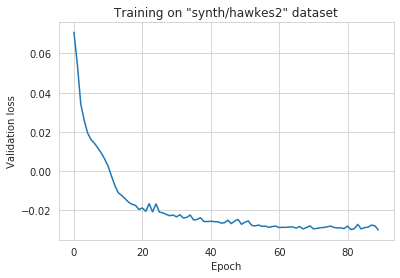

In [8]:
training_val_losses = training_val_losses[:-patience] # plot only until early stopping
plt.plot(range(len(training_val_losses)), training_val_losses)
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.title(f'Training on "{dataset_name}" dataset')
plt.show()